In [24]:
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt

#!pip install umap-learn==0.5.3
from umap import umap_ as umap

#!pip install networkx==2.4
import networkx as nx

#!pip install python-igraph
import igraph as ig

one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')
# specify experiment ID
eid = '19e66dc9-bf9f-430b-9d6a-acfa85de6fb7'


In [38]:
def get_waveforms(eid):
    #Waveforms has shape (nr_units, nr_timepoints, 32_top_waveforms_channel (out of ca 300))
    waveforms = one.load_dataset(eid, 'clusters.waveforms')
    print(waveforms.shape)
    waveform_channels = one.load_dataset(eid, 'clusters.waveformsChannels')
    print(waveform_channels.shape)
    unnormWFs=[]
    
    channels=[]

    for i, waveform_channel in enumerate(waveform_channels):
        top_channel_index = np.squeeze(waveform_channel)[0]
        channels.append(top_channel_index)
        cluster_waveform = waveforms[i, :,0]
        unnormWFs.append(cluster_waveform)
        
    return unnormWFs,channels

def fit_model(unnormWFs,channels):
    import sklearn.preprocessing
    normWFs = sklearn.preprocessing.normalize(unnormWFs,norm = 'max')
    from umap import umap_ as umap
    reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1,metric='euclidean')
    mapper = reducer.fit(normWFs)
    from networkx import convert_matrix 
    G = convert_matrix.from_scipy_sparse_array(mapper.graph_)
    clustering = nx.community.louvain_partitions(G, seed=123,resolution=1.5)
    cl=next(clustering)
    
    clustering_solution=[]

    for i in range(0,normWFs.shape[0]):
        ind=0
        for j in cl:
            if i in j:
                clustering_solution.append(ind)
            ind+=1
    import pandas as pd
    from matplotlib import cm
    from matplotlib import pyplot as plt
    import seaborn as sns
    import colorcet as cc

    embedding = reducer.fit_transform(normWFs)
    umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
    umap_df['waveform'] = list(normWFs)
    umap_df['cluster_id'] = clustering_solution
    cmap = plt.get_cmap("CMRmap")
    palette = sns.color_palette(cc.glasbey, n_colors=len(set(clustering_solution)))
    colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
    umap_df['cluster_color'] = [palette[i] for i in clustering_solution]
    
    print(len(set(clustering_solution)))
    
    #from sklearn.manifold import TSNE

    #X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=60).fit_transform(normWFs)
    #plt.scatter(X_embedded[:,0], X_embedded[:,1], marker='o', s=5,c=umap_df['cluster_color'].tolist())
    return umap_df
    
unnormWFs, channels=get_waveforms(eid)
umap_df=fit_model(unnormWFs,channels)


(795, 82, 32)
(795, 32)
68


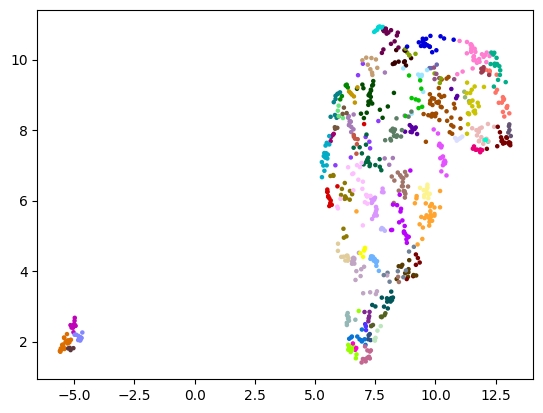

In [37]:
plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), marker='o', s=5,c=umap_df['cluster_color'].tolist())

In [39]:
one.list_datasets(eid)

['alf/_ibl_trials.goCueTrigger_times.npy',
 'alf/_ibl_trials.stimOff_times.npy',
 'alf/_ibl_trials.table.pqt',
 'alf/_ibl_wheel.position.npy',
 'alf/_ibl_wheel.timestamps.npy',
 'alf/_ibl_wheelMoves.intervals.npy',
 'alf/_ibl_wheelMoves.peakAmplitude.npy',
 'alf/probe00/electrodeSites.brainLocationIds_ccf_2017.npy',
 'alf/probe00/electrodeSites.localCoordinates.npy',
 'alf/probe00/electrodeSites.mlapdv.npy',
 'alf/probe00/pykilosort/_ibl_log.info_pykilosort.log',
 'alf/probe00/pykilosort/_kilosort_whitening.matrix.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.channels.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.spikes.npy',
 'alf/probe00/pykilosort/_phy_spikes_subset.waveforms.npy',
 'alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy',
 'alf/probe00/pykilosort/channels.localCoordinates.npy',
 'alf/probe00/pykilosort/channels.mlapdv.npy',
 'alf/probe00/pykilosort/channels.rawInd.npy',
 'alf/probe00/pykilosort/clusters.amps.npy',
 'alf/probe00/pykilosort/clusters.ch